## SFC Meteorology Obs from:
** - 2019 M2 (BSITAEPR-2A) **   
*** - 2019 M2 (BSM-2A) ***

__pyversion__==3.6   
__author__==S.Bell

In [32]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-07-01 11:29:57.558191


### connecting to erddap and retrieving and basic information

In [33]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [34]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='a_met'))

In [35]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 4 tabledap, 0 griddap, and 0 wms endpoints.'

In [36]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_17ckitaem2a_met' 'erddap_18bsitaepr2a_met'
 'erddap_18mtitaepr1a_met' 'erddap_19bsitaepr2a_met']


In [37]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['time', 'air_pressure', 'northward_wind', 'longitude', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'eastward_wind', 'air_temperature', 'latitude'], ['time', 'air_pressure', 'northward_wind', 'longitude', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'eastward_wind', 'air_temperature', 'latitude'], ['time', 'air_pressure', 'northward_wind', 'longitude', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'eastward_wind', 'air_temperature', 'latitude'], ['time', 'air_pressure', 'northward_wind', 'longitude', 'relative_humidity', 'eastward_wind', 'air_temperature', 'latitude']]


### getting Peggy Buoy (BSM-2A) Data

In [38]:
wdf = pd.read_csv('http://pavlof.pmel.noaa.gov/bell/ArgosMooring/data/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

In [39]:
wdf = wdf.resample('1H').mean()

### retrieving erddap and plotting data

In [40]:
constraints = {
    'time>=': '2019-04-25T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
# 'wind_from_direction', 
 'air_temperature',
 'relative_humidity',
 'northward_wind', 
 'eastward_wind', 
# 'wind_speed', 
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_17ckitaem2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18bsitaepr2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18mtitaepr1a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_19bsitaepr2a_met:
timeseries_id,latitude,longitude,time,northward_wind,air_pressure,relative_humidity,air_temperature,eastward_wind


In [41]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_19bsitaepr2a_met']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            if row['Dataset ID'] in ['erddap_19bsitaepr2a_met']:
                e.variables=variables + ['air_pressure']
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time (UTC)',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_19bsitaepr2a_met


In [42]:
df=dfs['erddap_19bsitaepr2a_met']
df.columns

Index(['air_temperature', 'relative_humidity', 'northward_wind',
       'eastward_wind', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'air_pressure'],
      dtype='object')

### Take care of any preliminary QC

In [43]:
#calculate windspeed and direction
df['wind_speed (m s-1)']=np.sqrt(df['northward_wind']**2 + df['eastward_wind']**2)
df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind'],
                                                                 df['eastward_wind']))

df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360


In [44]:
#eliminate unlikely wind and pressure extremes
for ds, df in dfs.items():
    df['wind_speed (m s-1)'][df['wind_speed (m s-1)']>100] = np.nan
    df['air_pressure'][df['air_pressure']<940] = np.nan
    df['air_temperature'][df['air_temperature']>150] = np.nan
    
#Arbitrary QC points based on evaluating plot / local characteristics and not broad science boundaries
wdf.WS[wdf.WS>25] = np.nan
wdf.RH[wdf.RH<25] = np.nan
wdf.BP[wdf.BP<975] = np.nan

### Plot

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

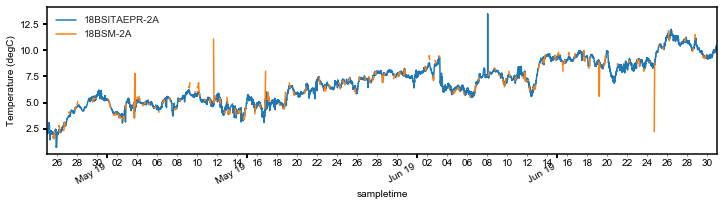

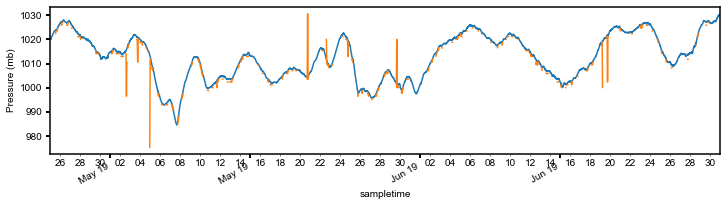

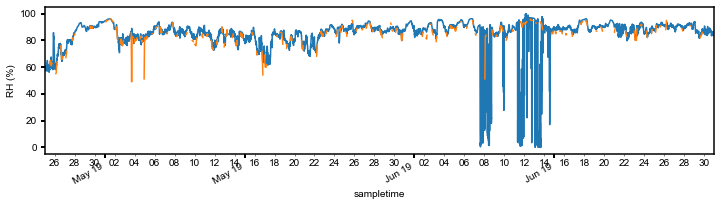

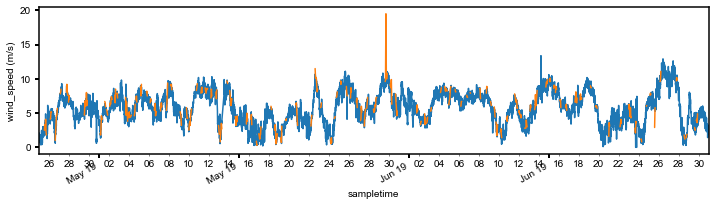

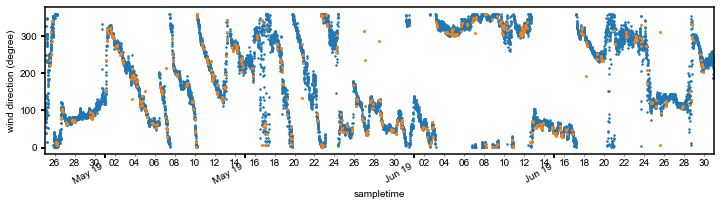

In [46]:
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['air_temperature'].plot(ax=ax)
        plt.ylabel('Temperature (degC)')
    except:
        pass
wdf.AT.plot(ax=ax)
plt.legend(['18BSITAEPR-2A','18BSM-2A'])
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['air_pressure'].plot(ax=ax)
        plt.ylabel('Pressure (mb)')
    except:
        df['air_pressure (mbar)'].plot(ax=ax)
        plt.ylabel('Pressure (mb)')
wdf.BP.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['relative_humidity'].plot(ax=ax)
        plt.ylabel('RH (%)')
    except:
        pass
wdf.RH.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
    
fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['wind_speed (m s-1)'].plot(ax=ax)
        plt.ylabel('wind_speed (m/s)')
    except:
        pass
wdf.WS.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['wind_from_direction (degrees true)'].plot(style='.',markersize=3.0,ax=ax)
        plt.ylabel('wind direction (degree)')
    except:
        pass
wdf.WD.plot(style='.',markersize=4.0,ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

In [47]:
wdf.tail()

,argosid,latitude,longitude,BP,AT,BV,RH,WS,WD,SR,AZ
sampletime,,,,,,,,,,,
2019-06-29 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-29 18:00:00,28882.0,56.871000,164.0695,1027.058824,9.2,14.0,85.0,3.9,224.481152,428.242012,271.07158
2019-06-29 19:00:00,28882.0,56.871667,164.0710,1027.058824,9.3,14.0,86.0,4.1,221.657490,113.465832,271.07158
2019-06-29 20:00:00,28882.0,56.871667,164.0710,1027.058824,9.4,14.0,85.0,3.6,203.303685,170.198748,271.07158
2019-06-29 21:00:00,28882.0,56.873000,164.0740,1027.058824,9.5,14.0,85.0,4.9,217.421996,181.179313,271.07158


In [48]:
df.tail()

,air_temperature,relative_humidity,northward_wind,eastward_wind,latitude (degrees_north),longitude (degrees_east),air_pressure,wind_speed (m s-1),wind_from_direction (degrees true)
time (UTC),,,,,,,,,
2019-06-30 22:50:00+00:00,10.17,86.42,2.9,1.1,56.873,-164.065,1030.18,3.101612,200.772255
2019-06-30 23:00:00+00:00,10.15,86.54,2.9,1.1,56.873,-164.065,1030.25,3.101612,200.772255
2019-06-30 23:10:00+00:00,10.21,86.93,2.6,1.6,56.873,-164.065,1030.27,3.052868,211.607502
2019-06-30 23:20:00+00:00,10.18,87.12,2.6,1.8,56.873,-164.065,1030.31,3.162278,214.695154
2019-06-30 23:30:00+00:00,10.19,87.23,2.7,1.8,56.873,-164.065,1030.34,3.244996,213.690068


### Next Steps

**TODO:** Plot top prawler bin/air temp for a SST/Air analysis